In [2]:
%env GOOGLE_CLOUD_PROJECT=latent-state-learning

env: GOOGLE_CLOUD_PROJECT=latent-state-learning


In [3]:
from pprint import pprint
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import json

In [4]:
STORE_NEW_DATA = False

if STORE_NEW_DATA:
    import firebase_admin
    from firebase_admin import firestore

    app = firebase_admin.initialize_app()
    db = firestore.client()

In [5]:
experiments_raw = []
if STORE_NEW_DATA:
    # Fetch all the experiments
    def get_new_docs_stream():
        return db.collection("experiments").stream()

    for doc in get_new_docs_stream():
        trials = []
        for i, trial in enumerate(doc.to_dict()['trials']):
            trials.append(trial)
        experiments_raw.append({
            'experiment_id': doc.id,
            'trials': trials,
        })
    
    # Store the data in a local file
    with open('experiments_raw.json', 'w') as f:
        f.write(json.dumps(experiments_raw))
else:
    # Load the data from a local file
    with open('experiments_raw.json', 'r') as f:
        experiments_raw = json.loads(f.read())

print(f'Total number of experiments: {len(experiments_raw)}')
# pprint(experiments_raw)

Total number of experiments: 4


In [6]:
experiments_raw

[{'experiment_id': '08RhyMkWazAYctYKnynL',
  'trials': [{'success': True,
    'trial_type': 'preload',
    'failed_video': {},
    'time_elapsed': 415,
    'internal_node_id': '0.0-0.0',
    'failed_audio': {},
    'failed_images': {},
    'timeout': False,
    'trial_index': 0},
   {'rt': 723,
    'trial_type': 'html-keyboard-response',
    'time_elapsed': 1139,
    'internal_node_id': '0.0-1.0',
    'stimulus': '<h1>Welcome to the experiment!</h1><p>Press any key to continue.</p>',
    'response': ' ',
    'trial_index': 1},
   {'rt': 1778,
    'trial_type': 'html-keyboard-response',
    'time_elapsed': 2917,
    'internal_node_id': '0.0-2.0',
    'stimulus': '<h1>Experiment</h1>\n<p>In this experiment, you will play a treasure sorting game.</p>\n    <p>Press any key to continue.</p>',
    'response': ' ',
    'trial_index': 2},
   {'rt': 183,
    'trial_type': 'html-keyboard-response',
    'time_elapsed': 3101,
    'internal_node_id': '0.0-3.0',
    'stimulus': '<h1>Experiment</h1>\

In [7]:
# Preprocess the experiments
experiments = []
for experiment in experiments_raw:
    trials = []
    for trial in experiment['trials']:
        preprocessed_trial = {
            **trial
        }
        if trial['trial_type'] in ['dragndrop', 'html-button-response', 'html-keyboard-response', 'survey-multi-select', 'webgazer-validate', 'browser-check'] and 'tutorial' not in trial:
            if 'drag_data' in trial:
                drag_data = trial['drag_data'] # { "0": [{ "x": 0, "y": 0, "t": 0 }, { "x": 0, "y": 0, "t": 0 }], "1": [{ "x": 0, "y": 0, "t": 0 }, { "x": 0, "y": 0, "t": 0 }] }
                # sort by dict key
                converted_drag_data = []
                for i in range(len(drag_data)):
                    converted_drag_data.append(drag_data[str(i)])
                for i, val in enumerate(converted_drag_data):
                    converted_drag_data[i] = sorted(val, key=lambda x: x['time'])
                preprocessed_trial['drag_data'] = converted_drag_data
                
                bucks = []
                for i in range(len(trial['buckets'])):
                    bucks.append(trial['buckets'][str(i)])
                preprocessed_trial['buckets'] = bucks
                
            
            if 'webgazer_data' in trial:
                webgazer_data = trial['webgazer_data']
                webgazer_data = sorted([webgazer_data[key] for key in webgazer_data], key=lambda x: x['t'])
                preprocessed_trial['webgazer_data'] = webgazer_data
                
            if 'mouse_tracking_data' in trial:
                mouse_data = trial['mouse_tracking_data']
                mouse_data = sorted([mouse_data[key] for key in mouse_data], key=lambda x: x['t'])
                preprocessed_trial['mouse_tracking_data'] = mouse_data
                
            if 'raw_gaze' in trial: # fixation point
                raw_gaze = trial['raw_gaze']
                converted_raw_gaze = []
                for i in range(len(raw_gaze)):
                    converted_raw_gaze.append(raw_gaze[str(i)])
                for i, val in enumerate(converted_raw_gaze):
                    converted_raw_gaze[i] = sorted(val, key=lambda x: x['t'])
                preprocessed_trial['raw_gaze'] = converted_raw_gaze

                average_offset = trial['average_offset']
                average_offset = [average_offset[key] for key in average_offset]
                preprocessed_trial['average_offset'] = average_offset
                validation_points = trial['validation_points']
                validation_points = [validation_points[key] for key in validation_points]
                preprocessed_trial['validation_points'] = validation_points
                percent_in_roi = trial['percent_in_roi']
                percent_in_roi = [percent_in_roi[key] for key in percent_in_roi]
                preprocessed_trial['percent_in_roi'] = percent_in_roi
            
            trials.append(preprocessed_trial)

    experiments.append({
        'experiment_id': experiment['experiment_id'],
        'completed': len(trials) > 0 and any(trial['trial_type'] == 'survey-multi-select' for trial in experiment['trials']),
        'trials': trials,
    })
    
print(f'Total number of experiments with at least one trial: {len(experiments)}')
print(f'Total number of completed experiments: {len([experiment for experiment in experiments if experiment["completed"]])}')
pprint(experiments)

Total number of experiments with at least one trial: 4
Total number of completed experiments: 1
[{'completed': False,
  'experiment_id': '08RhyMkWazAYctYKnynL',
  'trials': [{'internal_node_id': '0.0-1.0',
              'response': ' ',
              'rt': 723,
              'stimulus': '<h1>Welcome to the experiment!</h1><p>Press any key '
                          'to continue.</p>',
              'time_elapsed': 1139,
              'trial_index': 1,
              'trial_type': 'html-keyboard-response'},
             {'internal_node_id': '0.0-2.0',
              'response': ' ',
              'rt': 1778,
              'stimulus': '<h1>Experiment</h1>\n'
                          '<p>In this experiment, you will play a treasure '
                          'sorting game.</p>\n'
                          '    <p>Press any key to continue.</p>',
              'time_elapsed': 2917,
              'trial_index': 2,
              'trial_type': 'html-keyboard-response'},
             {'intern

In [8]:
stim_1_path = '../public/images/stimulus/animal_1.png'
stim_2_path = '../public/images/stimulus/animal_2.png'
stim_3_path = '../public/images/stimulus/animal_3.png'
stim_4_path = '../public/images/stimulus/animal_4.png'

basket_blue_path = '../public/images/baskets/basket_blue.png'
basket_green_path = '../public/images/baskets/basket_green.png'
basket_red_path = '../public/images/baskets/basket_red.png'
basket_yellow_path = '../public/images/baskets/basket_yellow.png'

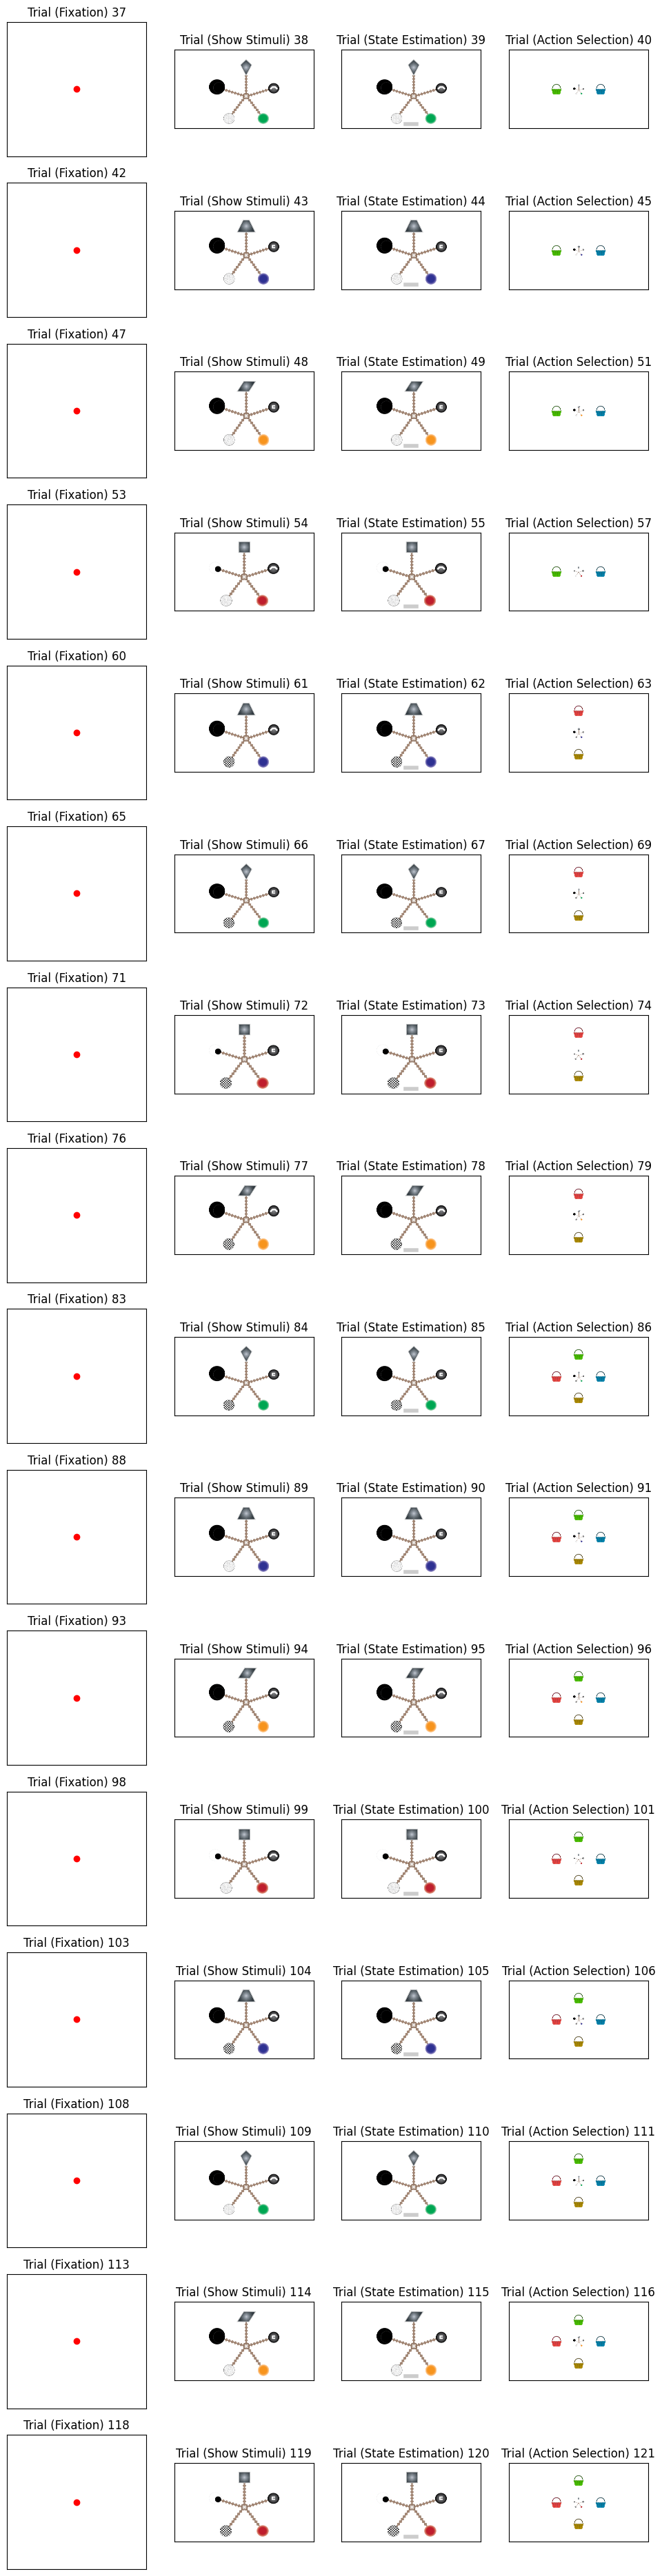

In [40]:
def get_skeleton_experiment_plot(preprocessed_experiment):
    # get browser data
    browser_check_trial = None
    for trial in preprocessed_experiment['trials']:
        if trial['trial_type'] == 'browser-check':
            browser_check_trial = trial
            break
    screen_width = browser_check_trial['width']
    screen_height = browser_check_trial['height']
        
    n_trials = len([t for t in preprocessed_experiment['trials'] if t['trial_type'] == 'dragndrop' and 'tutorial' not in t])
    
    cols = 4
    rows = (n_trials * 4 + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    ax_i = 0
    ax_trials = []
    ax_axes = []
    for trial_i, trial in enumerate(preprocessed_experiment['trials']):
        if trial['trial_type'] != 'dragndrop' and 'tutorial' not in trial:
            continue
        current_ax_axes = []
        # fixation point
        fixation_trial = None
        for i in range(trial_i-1, -1, -1):
            if 'my_trial_type' in preprocessed_experiment['trials'][i] and preprocessed_experiment['trials'][i]['my_trial_type'] == 'fixation-point':
                fixation_trial = preprocessed_experiment['trials'][i]
                break
        if rows == 1:
            ax = axs[ax_i % cols]
        else:
            ax = axs[ax_i // cols, ax_i % cols]
        ax.set_title(f'Trial (Fixation) {fixation_trial['trial_index']}')
        ax.set_ylim(0, screen_height)
        if screen_width / screen_height > 16/9:
            ax.set_xlim(screen_width/2 - screen_height*16/9 / 2, screen_width/2 + screen_height*16/9 / 2)
        else:
            ax.set_xlim(0, screen_width)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # draw a point at the center
        ax.plot(screen_width/2, screen_height/2, 'ro')
        
        current_ax_axes.append(ax)
        ax_i += 1

        # Show stimuli trial
        show_stimuli_trial = None
        for i in range(trial_i-1, -1, -1):
            if 'my_trial_type' in preprocessed_experiment['trials'][i] and preprocessed_experiment['trials'][i]['my_trial_type'] == 'show-stimuli':
                show_stimuli_trial = preprocessed_experiment['trials'][i]
                break
        if rows == 1:
            ax = axs[ax_i % cols]
        else:
            ax = axs[ax_i // cols, ax_i % cols]
        ax.set_title(f'Trial (Show Stimuli) {show_stimuli_trial['trial_index']}')
        ax.set_ylim(0, screen_height)
        if screen_width / screen_height > 16/9:
            ax.set_xlim(screen_width/2 - screen_height*16/9 / 2, screen_width/2 + screen_height*16/9 / 2)
        else:
            ax.set_xlim(0, screen_width)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        stimuli = show_stimuli_trial['stimulus'] # <img src="images/stimulus/animal_2.png" width="50%" />
        stimuli_path = f"../public/{stimuli.split('"')[1]}"
        # show the stimuli
        ax.imshow(plt.imread(stimuli_path), extent=[
            screen_width/2-screen_width * 0.25/2,
            screen_width/2+screen_width * 0.25/2,
            screen_height/2-screen_width * 0.25/2,
            screen_height/2+screen_width * 0.25/2
        ])
        current_ax_axes.append(ax)
        ax_i += 1
            
        # State Estimation Trial
        state_estimation_trial = None
        for i in range(trial_i-1, -1, -1):
            if 'my_trial_type' in preprocessed_experiment['trials'][i] and preprocessed_experiment['trials'][i]['my_trial_type'] == 'state-estimation':
                state_estimation_trial = preprocessed_experiment['trials'][i]
                break
        if rows == 1:
            ax = axs[ax_i % cols]
        else:
            ax = axs[ax_i // cols, ax_i % cols]
        ax.set_title(f'Trial (State Estimation) {state_estimation_trial['trial_index']}')
        ax.set_ylim(0, screen_height)
        if screen_width / screen_height > 16/9:
            ax.set_xlim(screen_width/2 - screen_height*8/9, screen_width/2 + screen_height*8/9)
        else:
            ax.set_xlim(0, screen_width)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax.imshow(plt.imread(stimuli_path), extent=[
            screen_width/2-screen_width * 0.25/2,
            screen_width/2+screen_width * 0.25/2,
            screen_height/2-screen_width * 0.25/2,
            screen_height/2+screen_width * 0.25/2
        ])
        # draw a thick horizontal line at the bottom
        ax.plot(
            [screen_width/2-100, screen_width/2+100],
            [screen_height/2-screen_width * 0.25/2, screen_height/2-screen_width * 0.25/2],
            color='black', linewidth=4, alpha=0.2)
            
        current_ax_axes.append(ax)
        ax_i += 1
            
        # Action Selection
        action_selection_trial = trial
        if rows == 1:
            ax = axs[ax_i % cols]
        else:
            ax = axs[ax_i // cols, ax_i % cols]
        ax.set_title(f'Trial (Action Selection) {action_selection_trial['trial_index']}')
        ax.set_ylim(0, screen_height)
        if screen_width / screen_height > 16/9:
            ax.set_xlim(screen_width/2 - screen_height*8/9, screen_width/2 + screen_height*8/9)
        else:
            ax.set_xlim(0, screen_width)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        bucket_width = 200
        bucket_height = 200
        for i, bucket in enumerate(action_selection_trial['buckets']):
            bucket_path = f"../public/{bucket['name'][0]}"
            ax.imshow(plt.imread(bucket_path), extent=[bucket['x']-bucket_width/2, bucket['x']+bucket_width/2, bucket['y']-bucket_height/2+100, bucket['y']+bucket_height/2+100])
        
        # draw the stimuli at the center smaller
        ax.imshow(plt.imread(stimuli_path), extent=[
            screen_width/2-200/2,
            screen_width/2+200/2,
            screen_height/2-200/2,
            screen_height/2+200/2
        ])
        
        # TODO: draw a square around the dropped bucket, green if correct, red if incorrect

        current_ax_axes.append(ax)
        ax_i += 1
        
        ax_trials.append([fixation_trial, show_stimuli_trial, state_estimation_trial, action_selection_trial])
        ax_axes.append(current_ax_axes)
    
    return fig, ax_axes, ax_trials

for exp in experiments:
    if exp['completed']:
        get_skeleton_experiment_plot(exp)

Visualizing drag_data experiment UI1BghVKdZjPP1bW8I4y


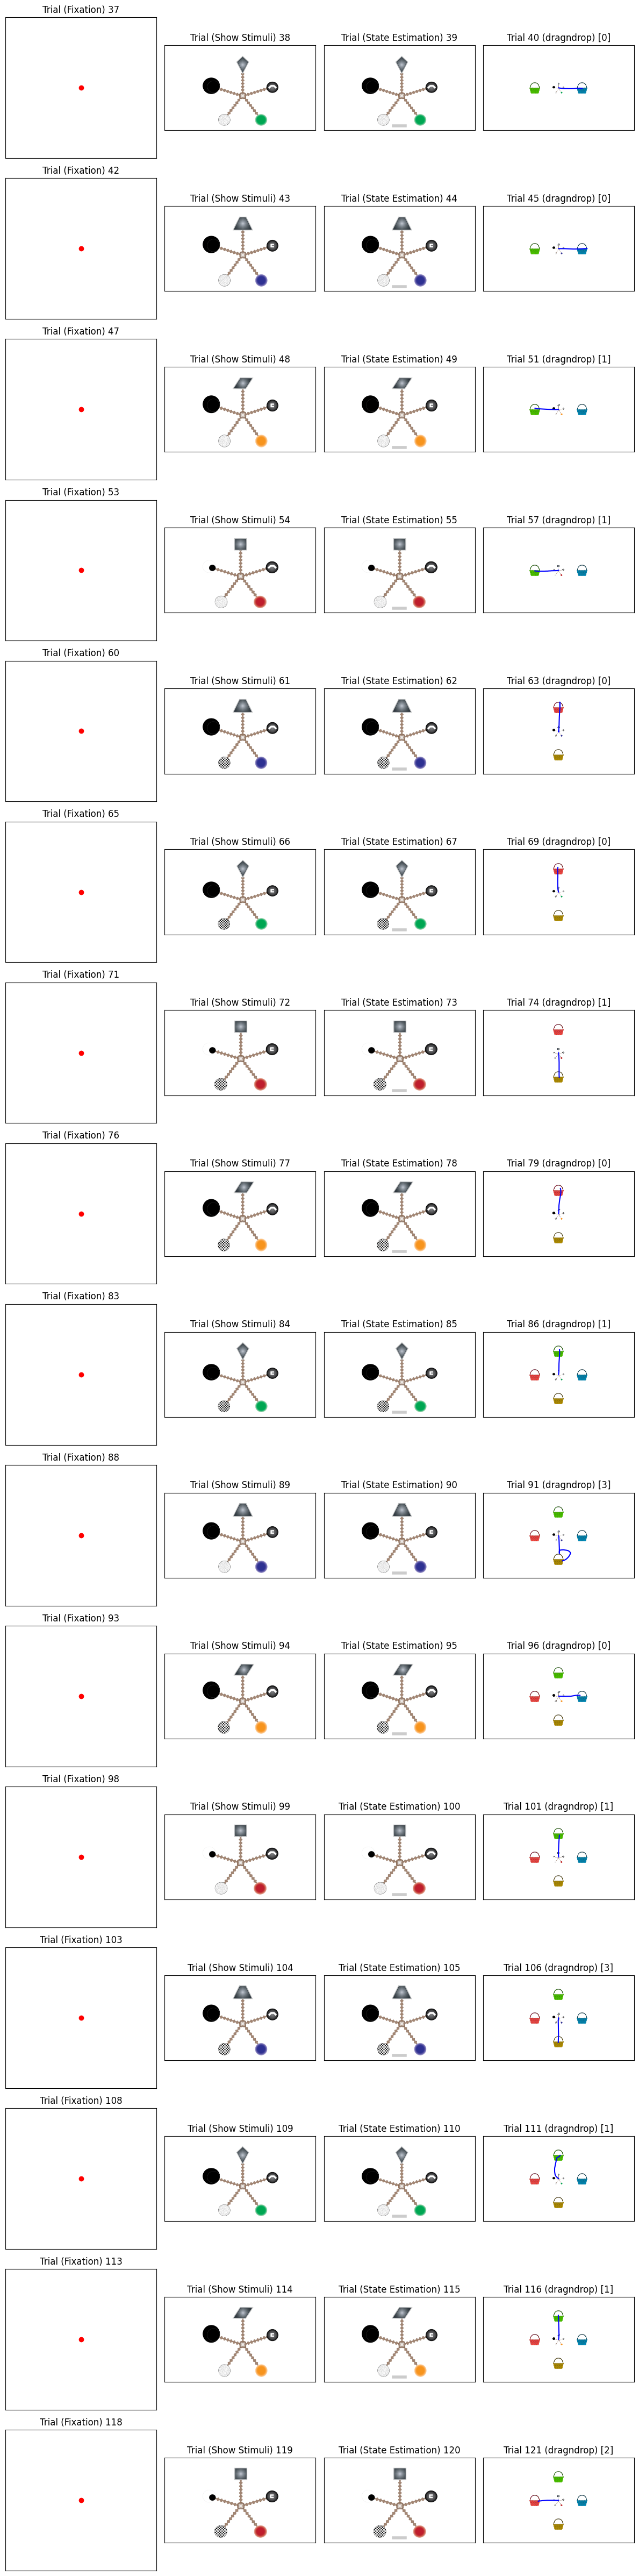

In [43]:
def visualize_experiment_drag_data(preprocessed_experiment):
    '''For each trial, show a white image where the drag data is drawn as a line'''
    print(f'Visualizing drag_data experiment {preprocessed_experiment["experiment_id"]}')
    
    fig, ax_axes, ax_trials = get_skeleton_experiment_plot(preprocessed_experiment)
    
    for axs, trials in zip(ax_axes, ax_trials):
        action_selection_trial = trials[3]
        ax = axs[3]
        if 'drag_data' in action_selection_trial:
            for i, drag_data in enumerate(action_selection_trial['drag_data']):
                ax.plot([d['x'] for d in drag_data], [d['y']+100 for d in drag_data], label='Drag data', color='blue' if i == 0 else 'red')
            
            # get maximum distance between buckets
            bucket_dist = 0
            for i, bucket1 in enumerate(action_selection_trial['buckets']):
                for j, bucket2 in enumerate(action_selection_trial['buckets']):
                    dist = np.sqrt((bucket1['x'] - bucket2['x'])**2 + (bucket1['y'] - bucket2['y'])**2)
                    if dist > bucket_dist:
                        bucket_dist = dist

            bucket_confusions = []
            for i, drag_data in enumerate(action_selection_trial['drag_data']):
                for j, point in enumerate(drag_data):
                    min_dist = float('inf')
                    min_bucket = None
                    for k, bucket in enumerate(action_selection_trial['buckets']):
                        dist = np.sqrt((point['x'] - bucket['x'])**2 + (point['y'] - bucket['y'])**2)
                        if dist < min_dist:
                            min_dist = dist
                            min_bucket = k
                    
                    # print(f'Point {j}: [{point['x']},{point['y']}] is closest to bucket {min_bucket} with distance {min_dist:.0f}')
                    if min_dist < bucket_dist / 3 and ((bucket_confusions and bucket_confusions[-1] != min_bucket) or not bucket_confusions):
                        bucket_confusions.append(min_bucket)
                        
            ax.set_title(f'Trial {action_selection_trial['trial_index']} ({action_selection_trial['my_trial_type']}) [{"->".join(map(str, bucket_confusions))}]')
            # ax.text(x_min, y_min, , fontsize=12, color='black')
                
    plt.tight_layout()
    plt.show()

for exp in experiments:
    if exp['completed']:
        visualize_experiment_drag_data(exp)

Visualizing eye gaze experiment UI1BghVKdZjPP1bW8I4y


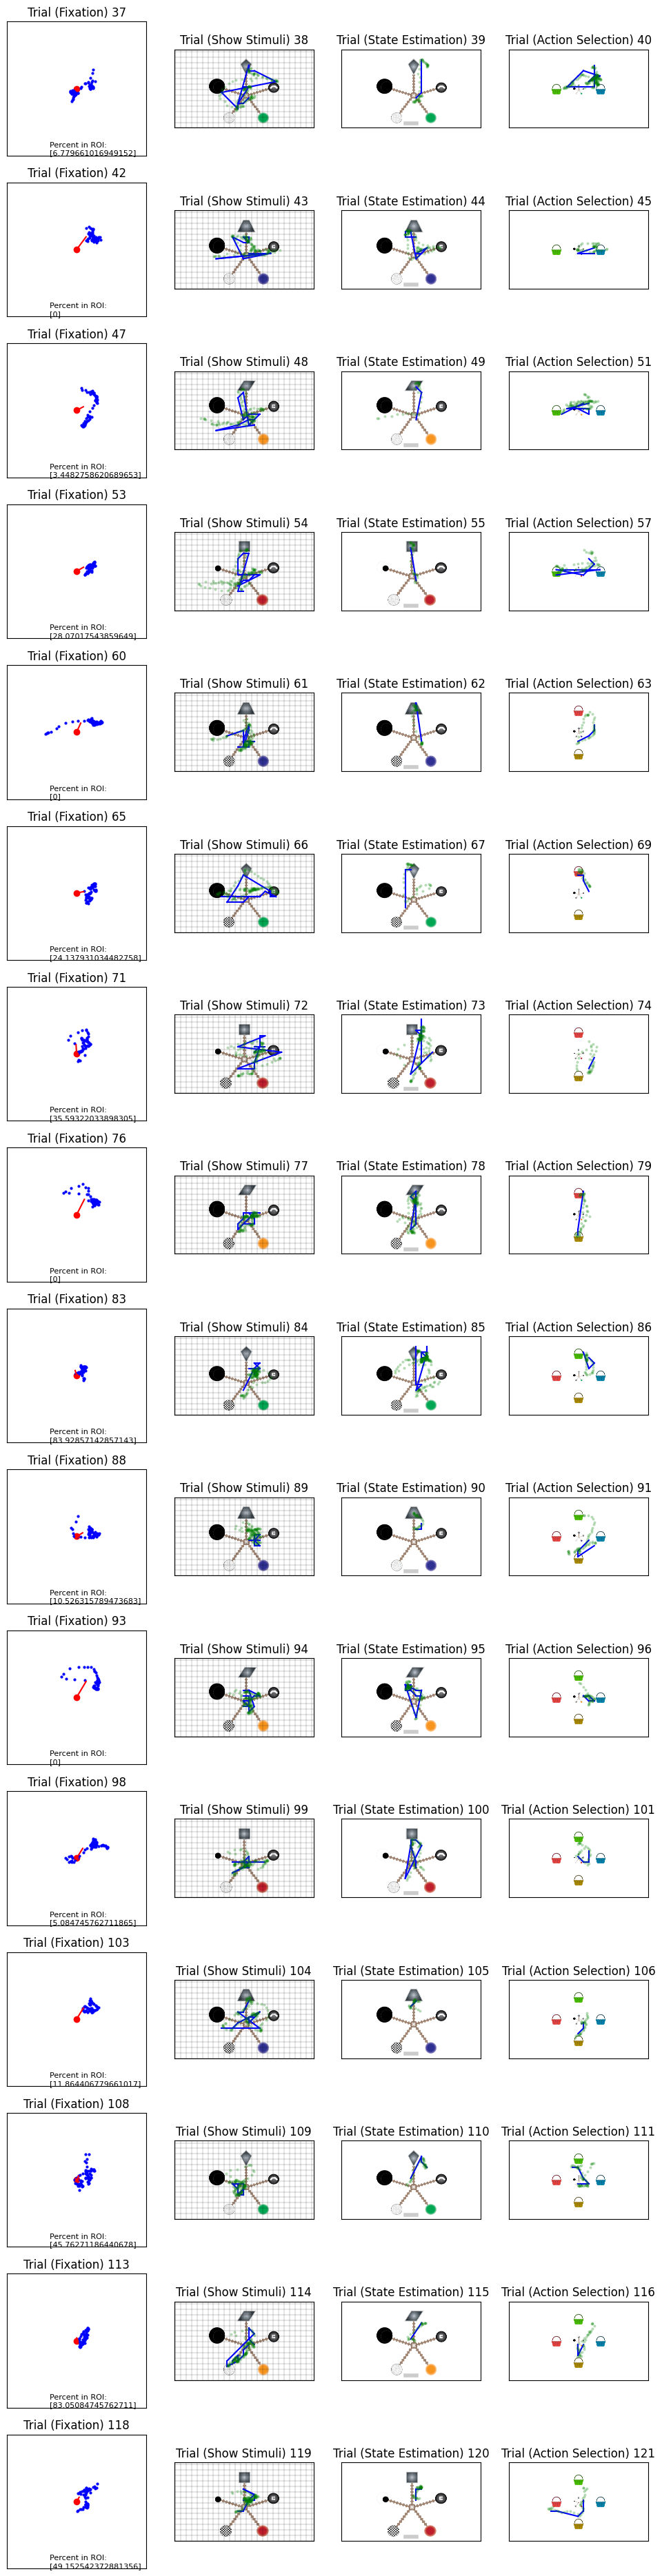

In [42]:
def visualize_experiment_eyegaze(preprocessed_experiment):
    '''For each trial, show a white image where the eye gaze data is drawn as dots'''
    print(f'Visualizing eye gaze experiment {preprocessed_experiment["experiment_id"]}')
    
    # get browser data
    browser_check_trial = None
    for trial in preprocessed_experiment['trials']:
        if trial['trial_type'] == 'browser-check':
            browser_check_trial = trial
            break
    screen_width = browser_check_trial['width']
    screen_height = browser_check_trial['height']
        
    fig, ax_axes, ax_trials = get_skeleton_experiment_plot(preprocessed_experiment)
    
    for axs, trials in zip(ax_axes, ax_trials):
        # fixation point
        fixation_trial = trials[0]
        ax = axs[0]
        for i, points in enumerate(fixation_trial['raw_gaze']):
            for j, point in enumerate(points):
                ax.plot(point['x'], point['y'], 'o', markersize=2, color='blue' if i == 0 else 'gray')
            
        for i, point in enumerate(fixation_trial['validation_points']):
            ax.plot(point[0] + screen_width/2, point[1] + screen_height/2, 'o', markersize=3, color='red')
            
        ax.text(screen_width/2-500, 10, f'Percent in ROI:\n{fixation_trial["percent_in_roi"]}', fontsize=8, color='black')
        
        # draw a line from the validation point to validation point + average offset
        for i, points in enumerate(fixation_trial['average_offset']):
            ax.plot(
                [
                    fixation_trial['validation_points'][i][0] + screen_width/2,
                    fixation_trial['validation_points'][i][0] + screen_width/2 + points['x']
                ],
                [
                    fixation_trial['validation_points'][i][1] + screen_height/2,
                    fixation_trial['validation_points'][i][1] + screen_height/2 + points['y']
                ],
                color='red'
            )

        # Show stimuli trial
        show_stimuli_trial = trials[1]
        ax = axs[1]
        # Draw a grid of 10x10
        cell_size = 100
        for x in range(0, screen_width, cell_size):
            ax.plot([x, x], [0, screen_height], color='black', alpha=0.1)
        for y in range(0, screen_height, cell_size):
            ax.plot([0, screen_width], [y, y], color='black', alpha=0.1)
            
        
        def get_refined_gaze(THRESHOLD, cell_size, gaze_data, offset):
            # Preprocess the webgazer_data as followingly
            # 1. Group the data into 10x10 cells of consecutive points
            # 2. Draw a line between the center of grid cells which cells have at least THRESHOLD points
            grid_cell_order = []
            for point in gaze_data[THRESHOLD:]:
                cell = (int((point['x'] - offset['x']) // cell_size), int((point['y'] - offset['x']) // cell_size))
                grid_cell_order.append(cell)
            # merge the cells that has at least THRESHOLD points in consecutive order, otherwise remove the cell
            merged_grid_cells = []
            current_cell = grid_cell_order[0]
            current_count = 1
            for cell in grid_cell_order[1:]:
                if cell == current_cell:
                    current_count += 1
                else:
                    if current_count >= THRESHOLD:
                        merged_grid_cells.append(current_cell)
                    current_cell = cell
                    current_count = 1
                    
            merged_grid_cells = [(c[0] * cell_size + cell_size/2, c[1] * cell_size + cell_size/2) for c in merged_grid_cells]

            return merged_grid_cells
                    
        refined_gaze = get_refined_gaze(3, 100, show_stimuli_trial['webgazer_data'], fixation_trial['average_offset'][0])
            
        for i in range(1, len(refined_gaze)):
            ax.plot(
                [
                    refined_gaze[i-1][0],
                    refined_gaze[i][0],
                ],
                [
                    refined_gaze[i-1][1],
                    refined_gaze[i][1],
                ],
                color='blue'
            )
        for i, point in enumerate(show_stimuli_trial['webgazer_data']):
            ax.plot(
                point['x'] - fixation_trial['average_offset'][0]['x'],
                point['y'] - fixation_trial['average_offset'][0]['y'],
                'o', markersize=2, color='green', alpha=0.2
            )
        
        # 5 locations of the image in equal distance from the center angular
        feature_locations = [
            
        ]
            
        # State Estimation Trial
        state_estimation_trial = trials[2]
        ax = axs[2]
        
        refined_gaze = get_refined_gaze(3, 100, state_estimation_trial['webgazer_data'], fixation_trial['average_offset'][0])
        
        for i in range(1, len(refined_gaze)):
            ax.plot(
                [
                    refined_gaze[i-1][0],
                    refined_gaze[i][0],
                ],
                [
                    refined_gaze[i-1][1],
                    refined_gaze[i][1],
                ],
                color='blue'
            )

        for i, point in enumerate(state_estimation_trial['webgazer_data']):
            ax.plot(
                point['x'] - fixation_trial['average_offset'][0]['x'],
                point['y'] - fixation_trial['average_offset'][0]['y'],
                'o', markersize=2, color='green', alpha=0.2
            )
            
        # Action Selection
        action_selection_trial = trials[3]
        ax = axs[3]

        refined_gaze = get_refined_gaze(3, 100, action_selection_trial['webgazer_data'], fixation_trial['average_offset'][0])
        
        for i in range(1, len(refined_gaze)):
            ax.plot(
                [
                    refined_gaze[i-1][0],
                    refined_gaze[i][0],
                ],
                [
                    refined_gaze[i-1][1],
                    refined_gaze[i][1],
                ],
                color='blue'
            )

        for i, point in enumerate(action_selection_trial['webgazer_data']):
            ax.plot(
                point['x'] - fixation_trial['average_offset'][0]['x'],
                point['y'] - fixation_trial['average_offset'][0]['y'],
                'o', markersize=2, color='green', alpha=0.2
            )
            
    plt.show()

for exp in experiments:
    if exp['completed']:
        visualize_experiment_eyegaze(exp)

Visualizing mouse data experiment UI1BghVKdZjPP1bW8I4y


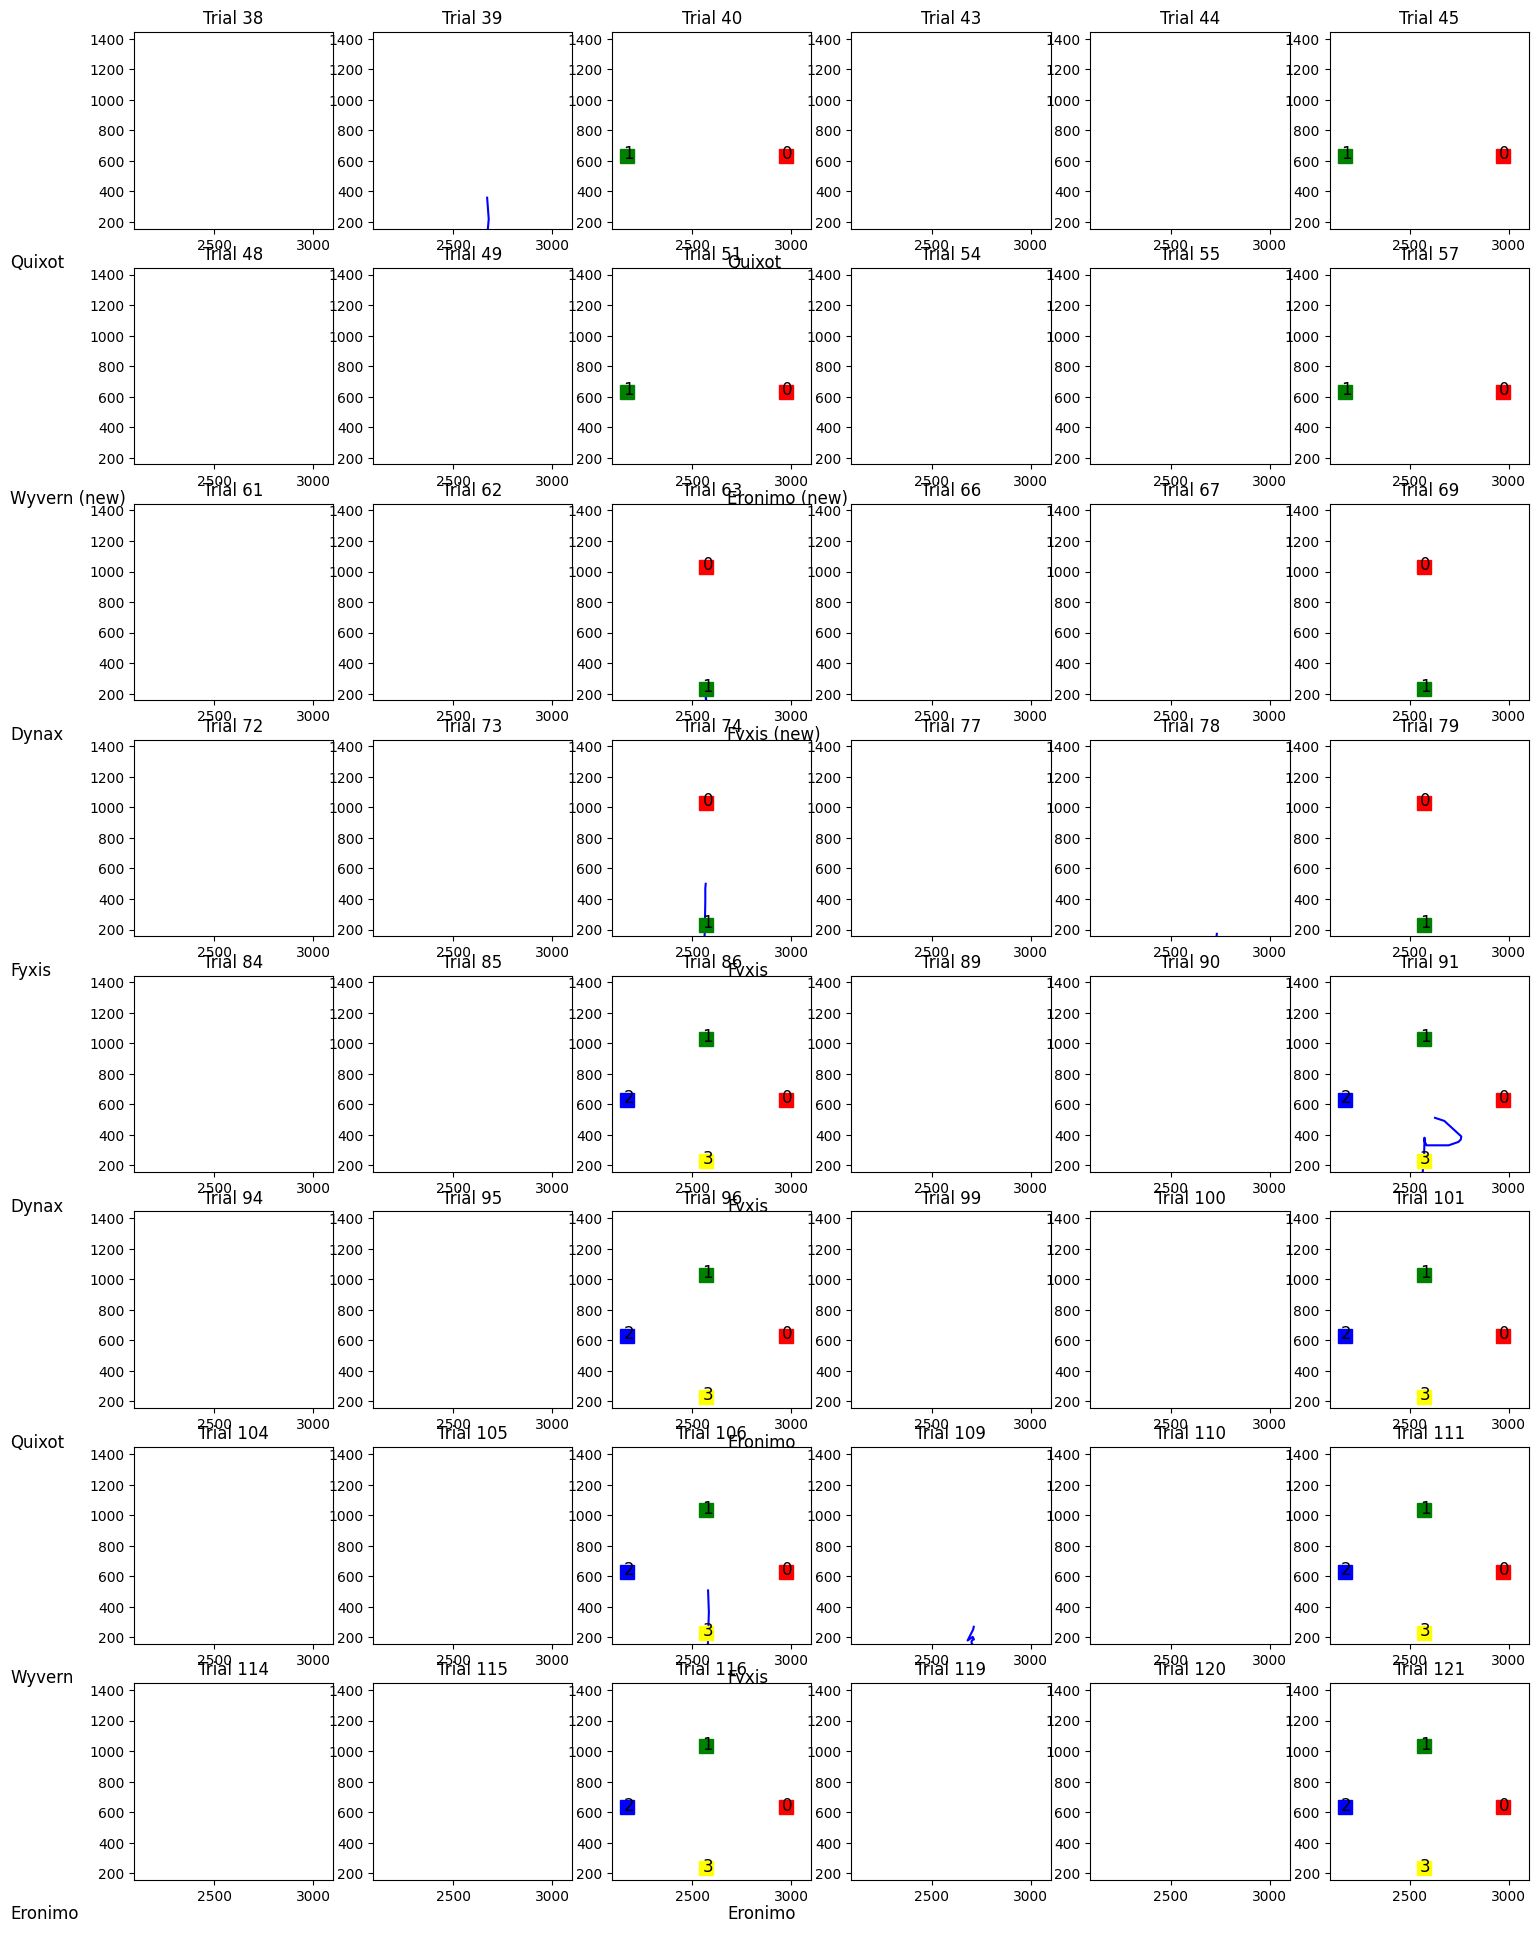

Visualizing mouse data experiment XnEKV0xTwheipkRWHWrJ
No mouse tracking trials found


In [45]:
def visualize_experiment_mouse_data(preprocessed_experiment):
    '''For each trial, show a white image where the mouse data is drawn as lines'''
    print(f'Visualizing mouse data experiment {preprocessed_experiment["experiment_id"]}')
    
    n_mouse_trials = sum('mouse_tracking_data' in trial for trial in preprocessed_experiment['trials'])
    if n_mouse_trials == 0:
        print('No mouse tracking trials found')
        return
    x_min = min([min([point['x'] for point in trial['mouse_tracking_data']]) for trial in preprocessed_experiment['trials'] if 'mouse_tracking_data' in trial and trial['mouse_tracking_data']])
    x_max = max([max([point['x'] for point in trial['mouse_tracking_data']]) for trial in preprocessed_experiment['trials'] if 'mouse_tracking_data' in trial and trial['mouse_tracking_data']])
    y_min = min([min([point['y'] for point in trial['mouse_tracking_data']]) for trial in preprocessed_experiment['trials'] if 'mouse_tracking_data' in trial and trial['mouse_tracking_data']])
    y_max = max([max([point['y'] for point in trial['mouse_tracking_data']]) for trial in preprocessed_experiment['trials'] if 'mouse_tracking_data' in trial and trial['mouse_tracking_data']])
    # print(f'Number of mouse trials: {n_mouse_trials}')
    cols = 6
    rows = (n_mouse_trials + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    trial_i = 0
    for trial in preprocessed_experiment['trials']:
        if 'mouse_tracking_data' in trial:
            if rows == 1:
                ax = axs[trial_i % cols]
            else:
                ax = axs[trial_i // cols, trial_i % cols]
            ax.set_title(f'Trial {trial['trial_index']}')
            ax.set_xlim(x_min - 100, x_max + 100)
            ax.set_ylim(y_min - 100, y_max + 100)
            # ax.get_xaxis().set_visible(False)
            # ax.get_yaxis().set_visible(False)

            center = [583 + 200/2, 284 + 200/2]
            ax.plot(
                [d['x'] for d in trial['mouse_tracking_data']], 
                [center[1] - (d['y']-center[1]) for d in trial['mouse_tracking_data']],
                label='Mouse data', color='blue'
            )
            
            if trial['trial_type'] == 'dragndrop':
                bucket_centers = [
                    [
                        trial['webgazer_targets'][f'#jspsych-dragndrop-bucket-{i}']['left'] + trial['webgazer_targets'][f'#jspsych-dragndrop-bucket-{i}']['width']/2,
                        trial['webgazer_targets'][f'#jspsych-dragndrop-bucket-{i}']['top'] + trial['webgazer_targets'][f'#jspsych-dragndrop-bucket-{i}']['height']/2,
                    ] for i in range(len(trial['buckets']))
                ]
                bucket_colors = ['red', 'green', 'blue', 'yellow']

                for i, bucket_center in enumerate(bucket_centers):
                    ax.plot(bucket_center[0], bucket_center[1], 's', markersize=10, color=bucket_colors[i])
                    ax.text(bucket_center[0]-20, bucket_center[1]-20, str(i), fontsize=12, color='black')
                
            elif trial['trial_type'] == 'html-keyboard-response':
                # draw 5 circles around the center with equal angle distance and radius 100
                radius = 250
                for i in range(5):
                    angle = i * 2 * np.pi / 5
                    x = center[0] + radius * np.sin(angle)
                    y = center[1] + radius * np.cos(angle)
                    ax.plot(x, y, 'o', markersize=10, color='red')
                # ax.plot(center[0], center[1], 'o', markersize=10, color='red')
            
            elif trial['trial_type'] == 'html-button-response':
                ax.text(260, -100, f'{trial["estimated_state"]}' + (' (new)' if trial['new_state'] else ''), fontsize=12, color='black')
            trial_i += 1

    plt.show()

for exp in experiments:
    visualize_experiment_mouse_data(exp)

In [11]:
# print number of trials per experiment
for exp in experiments:
    print(f'Experiment {exp["experiment_id"]} has {len(exp["trials"])} trials{"" if exp["completed"] else " (incomplete)"}')

Experiment G587cML7Z7SnWNWPUy4f has 76 trials (incomplete)
Experiment Mc7t4VWJH6tK3q8MRy15 has 0 trials (incomplete)
Experiment eSbnWbnPpWfeurLe0Jdf has 0 trials (incomplete)
Experiment kbs9e4kvs80qh9sIA3ng has 76 trials
Experiment r4JtXM2MrF9r8cC1Eq8r has 76 trials


# Experiment Performance Visualization

## State Estimation

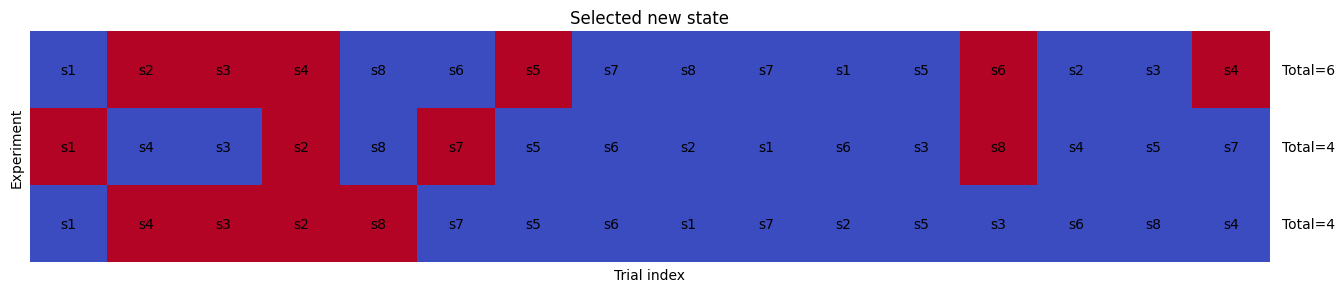

In [12]:
def state_estimation_experiment_selection_criteria(exp):
    '''Return True if the experiment meets the criteria for state estimation'''
    return len(exp['trials']) > 75
    
# which trials did they select a new state?
all_state_estimation_trials = [list(filter(
    lambda trial: 'estimated_state' in trial, 
    experiment['trials']
)) for experiment in experiments if state_estimation_experiment_selection_criteria(experiment)]

selected_new_state = [list(map(
    lambda trial: trial['new_state'],
    all_state_estimation_trial
)) for all_state_estimation_trial in all_state_estimation_trials]
# <img src="images/stimulus/animal_1.png" width="50%" />
# get '1' from the string
def get_stimulus_name(stimulus):
    return int(stimulus.split('>')[0].split('/')[-2].split('.')[0].split('_')[-1])

stimulus_in_trials = [list(map(
    lambda trial: get_stimulus_name(trial['stimulus']),
    all_state_estimation_trial
)) for all_state_estimation_trial in all_state_estimation_trials]

# draw a heatmap
plt.figure(figsize=(len(selected_new_state[0]), len(selected_new_state)))
sns.heatmap(selected_new_state, fmt='d', cmap='coolwarm', cbar=False, xticklabels=False, yticklabels=False)
# at each cell, show the stimulus name
for i in range(len(selected_new_state)):
    for j in range(len(selected_new_state[i])):
        plt.text(j+0.5, i+0.5, f's{stimulus_in_trials[i][j]}', ha='center', va='center', color='black')
plt.xlabel('Trial index')
plt.ylabel('Experiment')
plt.title('Selected new state')

# At the right side, show the total number of new states selected
new_states = [sum(selected_new_state[i]) for i in range(len(selected_new_state))]
for i, new_state in enumerate(new_states):
    plt.text(len(selected_new_state[0])+0.5, i+0.5, f'Total={new_state}', ha='center', va='center', color='black')

plt.show()

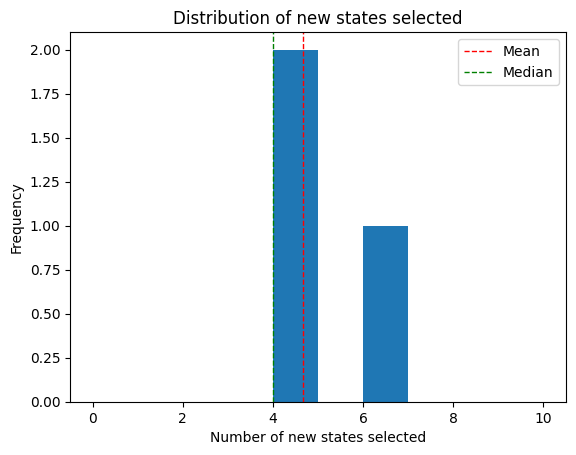

In [13]:
# Show a distribution of the number of new states selected
plt.hist(new_states, bins=range(0, 11))
plt.xlabel('Number of new states selected')
plt.ylabel('Frequency')
plt.title('Distribution of new states selected')
# draw the mean and median
plt.axvline(np.mean(new_states), color='red', linestyle='dashed', linewidth=1)
plt.axvline(np.median(new_states), color='green', linestyle='dashed', linewidth=1)
plt.legend(['Mean', 'Median'])
plt.show()

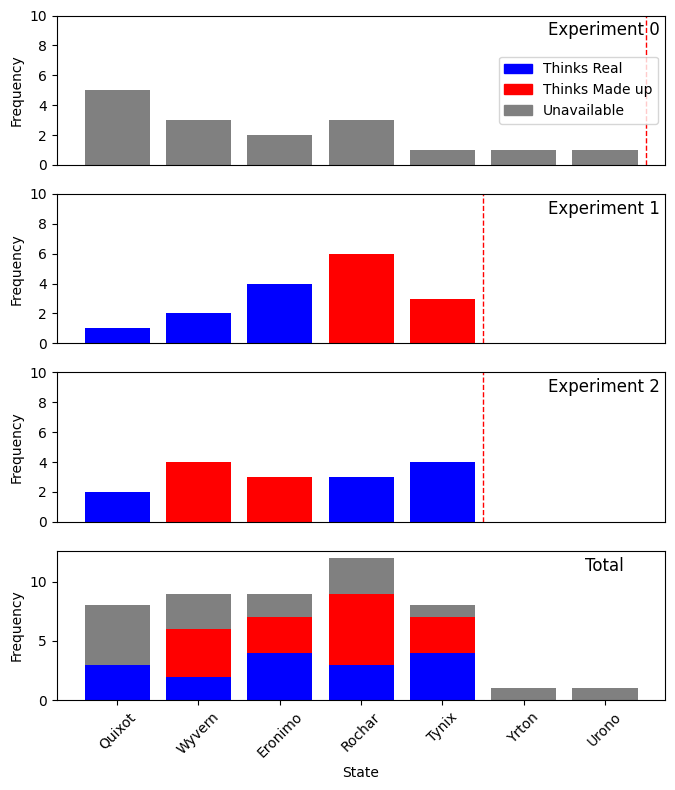

In [14]:
defined_states = ['Quixot', 'Wyvern', 'Eronimo', 'Rochar', 'Tynix', 'Yrton', 'Urono', 'Izor', 'Oronim', 'Pexis', 'Arctis', 'Syber', 'Dynax', 'Fyxis', 'Gyron', 'Hyxel', 'Jaltra', 'Kavra', 'Lyris']

selected_state = [list(map(
    lambda trial: trial['estimated_state'],
    all_state_estimation_trial
)) for all_state_estimation_trial in all_state_estimation_trials]

believed_states = []
for experiment in experiments:
    if not state_estimation_experiment_selection_criteria(experiment):
        continue
    if any(trial['trial_type'] == 'survey-multi-select' for trial in experiment['trials']):
        believed_states.append({
            'realTreasures': list(next(filter(
                lambda trial: trial['trial_type'] == 'survey-multi-select', 
                experiment['trials']
            ))['response']['realTreasures'].values()),
            'madeupTreasures': list(next(filter(
                lambda trial: trial['trial_type'] == 'survey-multi-select', 
                experiment['trials']
            ))['response']['madeupTreasures'].values()),
        })
    else:
        believed_states.append({
            'realTreasures': [],
            'madeupTreasures': [],
        })

# remove states that are not selected in any experiment
for si, state in enumerate(defined_states):
    if all([state not in selected_state_i for selected_state_i in selected_state]):
        defined_states = defined_states[:si]
        break

# visualize the number of times each state was selected for all the experiments
# each row will be a barchart for each experiment. In each barchart, the x-axis will be the defined states and the y-axis will be the number of times the state was selected
# One extra last row will show the total number of times each state was selected across all the experiments

plt.figure(figsize=(len(defined_states), (len(selected_state)+1)*2))
for i in range(len(selected_state)):
    plt.subplot(len(selected_state)+1, 1, i+1)
    # set the color of the bar to blue if they believed the state is real, and red if they believed the state is made up
    colors = ['blue' if state in believed_states[i]['realTreasures'] else 'red' if state in believed_states[i]['madeupTreasures'] else 'gray' for state in defined_states]
    # sns.histplot(selected_state[i], bins=range(0, len(defined_states)+1), color='blue', discrete=True)
    plt.bar(defined_states, [selected_state[i].count(state) for state in defined_states], color=colors)
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)
    plt.ylim(0, 10)
    # dont show the x-axis
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.text(0.9, 0.9, f'Experiment {i}', ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)

    # find the first state that has count = 0 and draw a vertical line
    for j, state in enumerate(defined_states):
        if selected_state[i].count(state) == 0:
            plt.axvline(j-0.5, color='red', linestyle='dashed', linewidth=1)
            break
    else:
        plt.axvline(len(defined_states)-0.5, color='red', linestyle='dashed', linewidth=1)

    if i == 0:
        color_legend_patches = []
        for color, label in {'blue': 'Thinks Real', 'red': 'Thinks Made up', 'gray': 'Unavailable'}.items():
            color_legend_patches.append(mpatches.Patch(color=color, label=label))
        plt.legend(handles=color_legend_patches, loc='right')


plt.subplot(len(selected_state)+1, 1, len(selected_state)+1)
x = np.arange(len(defined_states))
real_portion = [sum([selected_state[i].count(state) for i in range(len(selected_state)) if state in believed_states[i]['realTreasures']]) for state in defined_states]
madeup_portion = [sum([selected_state[i].count(state) for i in range(len(selected_state)) if state in believed_states[i]['madeupTreasures']]) for state in defined_states]
unavailable_portion = [sum([selected_state[i].count(state) for i in range(len(selected_state)) if state not in believed_states[i]['realTreasures'] and state not in believed_states[i]['madeupTreasures']]) for state in defined_states]
plt.bar(x, real_portion, color='blue', label='Thinks Real')
plt.bar(x, madeup_portion, color='red', bottom=real_portion, label='Thinks Made up')
plt.bar(x, unavailable_portion, color='gray', bottom=np.array(real_portion) + np.array(madeup_portion), label='Unavailable')

# plt.bar(defined_states, [sum([selected_state[i].count(state) for i in range(len(selected_state))]) for state in defined_states])


plt.text(0.9, 0.9, f'Total', ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
plt.ylabel('Frequency')
plt.xticks(rotation=45)
# xlabel
plt.xlabel('State')
plt.xticks(x, defined_states)
# plt.ylim(0, 10)
plt.tight_layout()
plt.show()

## Action Selection

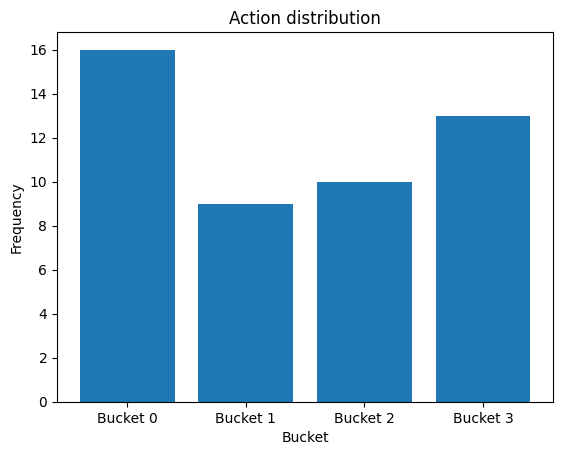

In [15]:
# action distribution
# This will show that the color and position of the buckets is not affecting the action distribution

action_selections_experiments = []
for experiment in experiments:
    if len(experiment['trials']) < 75:
        continue
    action_selections_experiment = []
    for ti, trial in enumerate(experiment['trials']):
        if trial['trial_type'] == 'dragndrop':
            action_selection_trial = {
                **trial,
                'estimated_state': experiment['trials'][ti-1]['estimated_state'] if experiment['trials'][ti-1]['trial_type'] == 'html-button-response' else experiment['trials'][ti-2]['estimated_state'],
                'stimuli': get_stimulus_name(experiment['trials'][ti-1]['stimulus']),
            }
            del action_selection_trial['webgazer_targets']
            del action_selection_trial['webgazer_data']
            del action_selection_trial['trial_type']
            del action_selection_trial['drag_data']
            del action_selection_trial['internal_node_id']
            del action_selection_trial['mouse_tracking_data']
            del action_selection_trial['mouse_tracking_targets']
            action_selections_experiment.append(action_selection_trial)
    action_selections_experiments.append(action_selections_experiment)

# plot the action distribution by trial['drop_bucket']
bucket_counts = [0, 0, 0, 0]
for experiment in action_selections_experiments:
    for trial in experiment:
        bucket_counts[trial['drop_bucket']] += 1

plt.bar(['Bucket 0', 'Bucket 1', 'Bucket 2', 'Bucket 3'], bucket_counts)
plt.xlabel('Bucket')
plt.ylabel('Frequency')
plt.title('Action distribution')
plt.show()


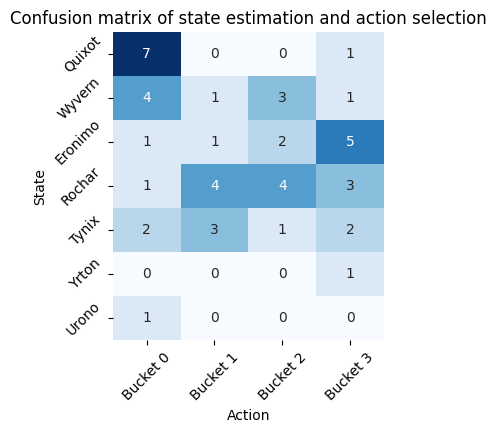

In [16]:
# show confusion matrix of state estimation and action selection
bucket_counts = [[0, 0, 0, 0] for _ in range(len(defined_states))]

for experiment in action_selections_experiments:
    for trial in experiment:
        bucket_counts[defined_states.index(trial['estimated_state'])][trial['drop_bucket']] += 1

plt.figure(figsize=(len(defined_states)/2, 4))
sns.heatmap(bucket_counts, fmt='d', annot=True, cmap='Blues', cbar=False, xticklabels=['Bucket 0', 'Bucket 1', 'Bucket 2', 'Bucket 3'], yticklabels=defined_states)
plt.xlabel('Action')
plt.ylabel('State')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title('Confusion matrix of state estimation and action selection')
plt.show()

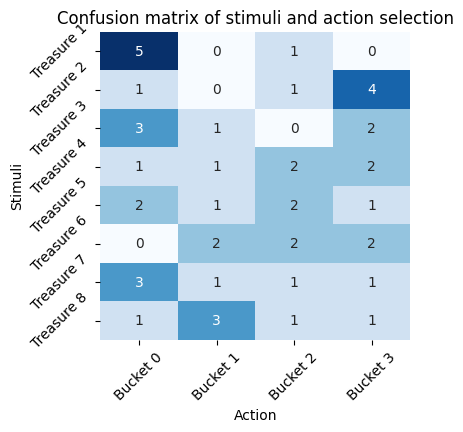

In [17]:
# show confusion matrix of stimuli and action selection
bucket_counts = [[0, 0, 0, 0] for _ in range(8)]

for experiment in action_selections_experiments:
    for trial in experiment:
        bucket_counts[trial['stimuli']-1][trial['drop_bucket']] += 1

plt.figure(figsize=(8/2, 4))
sns.heatmap(bucket_counts, fmt='d', annot=True, cmap='Blues', cbar=False, xticklabels=['Bucket 0', 'Bucket 1', 'Bucket 2', 'Bucket 3'], yticklabels=list(map(lambda x: f'Treasure {x}', range(1, 9))))
plt.xlabel('Action')
plt.ylabel('Stimuli')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title('Confusion matrix of stimuli and action selection')
plt.show()

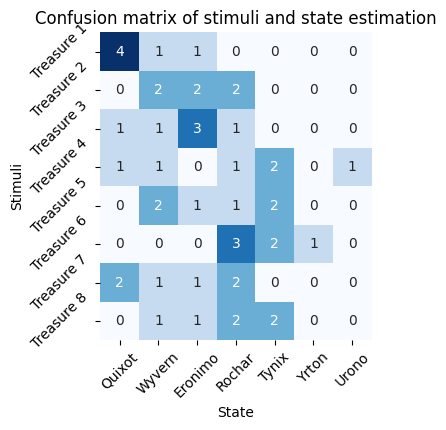

In [18]:
# show stimuli and state confusion matrix
bucket_counts = [[0 for s in defined_states] for _ in range(8)]

for experiment in action_selections_experiments:
    for trial in experiment:
        bucket_counts[trial['stimuli']-1][defined_states.index(trial['estimated_state'])] += 1

plt.figure(figsize=(len(defined_states)/2, 4))
sns.heatmap(bucket_counts, fmt='d', annot=True, cmap='Blues', cbar=False, xticklabels=defined_states, yticklabels=list(map(lambda x: f'Treasure {x}', range(1, 9))))
plt.xlabel('State')
plt.ylabel('Stimuli')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title('Confusion matrix of stimuli and state estimation')
plt.show()

## Reaction Time

In [19]:
# show line chart for 'time_elapsed' in all trial['trial_type'] == 'dragndrop'
rts_all = []
for experiment in experiments:
    rts = []

    rts += (np.geomspace(5000, 2000, num=4) * (1+0.05*np.random.normal(size=4))).tolist()
    rts += (np.geomspace(5000, 1000, num=4) * (1+0.15*np.random.normal(size=4))).tolist()
    rts += (np.geomspace(5000, 500, num=8) * (1+0.1*np.random.normal(size=8))).tolist()
    
    # for trial in experiment['trials']:
    #     if trial['trial_type'] == 'dragndrop':
    #         rts.append(trial['rt'])
    
    if rts:
        # normalize rts
        # rts = [(rt - min(rts)) / (max(rts) - min(rts)) for rt in rts]
        rts_all.append(rts)


plt.figure(figsize=(len(rts_all[0]), len(rts_all)))
for i, rts in enumerate(rts_all):
    sns.lineplot(x=range(0, 4), y=rts[:4])
    sns.lineplot(x=range(4, 8), y=rts[4:8])
    sns.lineplot(x=range(8, 16), y=rts[8:])
plt.xlabel('Trial index')
plt.ylabel('Response time (ms)')
plt.title('Response time for action selections')
plt.text(1.5, 600, 'Context 1', ha='center', va='center', color='black')
plt.text(5.5, 600, 'Context 2', ha='center', va='center', color='black')
plt.text(12, 600, 'Context 3', ha='center', va='center', color='black')
plt.legend()
plt.show()


KeyError: 'rt'

/tmp/ipykernel_522424/219528830.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


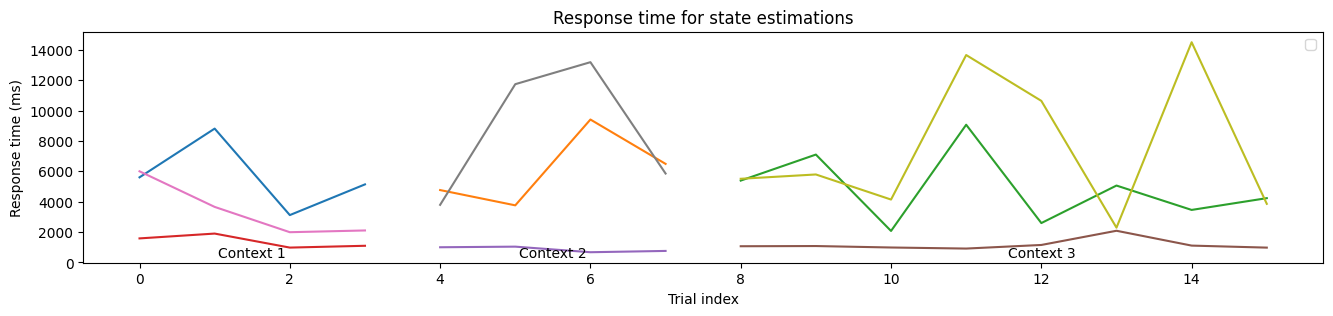

In [ ]:
# show line chart for 'time_elapsed' in all trial['trial_type'] == 'html-button-response' and 'estimated_state' in trial
rts_all = []
for experiment in experiments:
    rts = []
    for trial in experiment['trials']:
        if trial['trial_type'] == 'html-button-response' and 'estimated_state' in trial:
            rts.append(trial['rt'])
    
    if rts:
        # normalize rts
        # rts = [(rt - min(rts)) / (max(rts) - min(rts)) for rt in rts]
        rts_all.append(rts)

plt.figure(figsize=(len(rts_all[0]), len(rts_all)))
for i, rts in enumerate(rts_all):
    sns.lineplot(x=range(0, 4), y=rts[:4])
    sns.lineplot(x=range(4, 8), y=rts[4:8])
    sns.lineplot(x=range(8, 16), y=rts[8:])
plt.xlabel('Trial index')
plt.ylabel('Response time (ms)')
plt.title('Response time for state estimations')
plt.text(1.5, 600, 'Context 1', ha='center', va='center', color='black')
plt.text(5.5, 600, 'Context 2', ha='center', va='center', color='black')
plt.text(12, 600, 'Context 3', ha='center', va='center', color='black')
plt.legend()
plt.show()


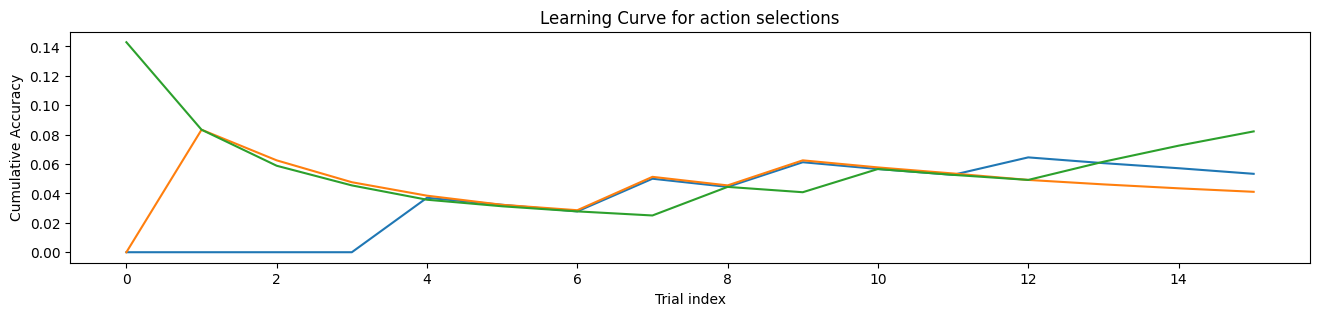

In [ ]:
# accuracy curve

acc_all = []
for experiment in experiments:
    acc = []
    for ti, trial in enumerate(experiment['trials']):
        if trial['trial_type'] == 'dragndrop':
            acc.append(sum([(1 if tj['is_correct'] else 0) for tj in experiment['trials'][:ti+1] if tj['trial_type'] == 'dragndrop']) / (ti+1))
    if acc:
        acc_all.append(acc)

plt.figure(figsize=(len(acc_all[0]), len(acc_all)))
for i, acc in enumerate(acc_all):
    sns.lineplot(x=range(len(acc)), y=acc)
plt.xlabel('Trial index')
plt.ylabel('Cumulative Accuracy')
plt.title('Learning Curve for action selections')
plt.show()


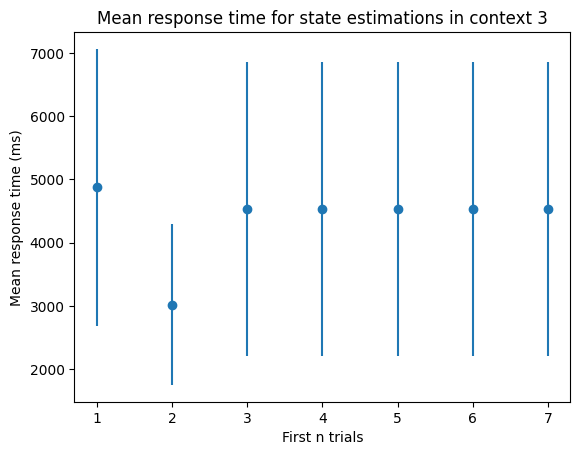

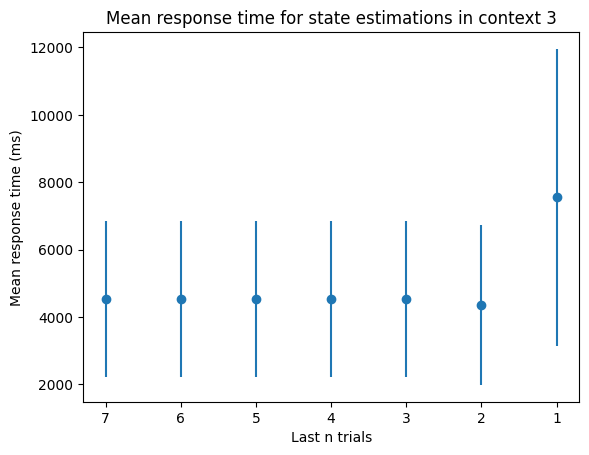

In [ ]:
# Mean reaction time during first n trials in context 3
rts_all = []
for experiment in experiments:
    rts = []
    for trial in experiment['trials']:
        if trial['trial_type'] == 'html-button-response' and 'estimated_state' in trial:
            rts.append(trial['rt'])
    
    if rts:
        # normalize rts
        # rts = [(rt - min(rts)) / (max(rts) - min(rts)) for rt in rts]
        rts_all.append(rts)


rts_context_3 = [rts[8:] for rts in rts_all]

avg_rts = []
std_rts = []
for first_n_trials in range(1, 8):
    first_mean_rts_context_3 = np.mean([np.mean(rts) for rts in rts_context_3[:first_n_trials]])
    first_std_rts_context_3 = np.mean([np.std(rts) for rts in rts_context_3[:first_n_trials]])
    avg_rts.append(first_mean_rts_context_3)
    std_rts.append(first_std_rts_context_3)

plt.errorbar(
    range(1, 8),
    avg_rts, 
    yerr=std_rts,
    fmt='o'
)
plt.xlabel('First n trials')
plt.ylabel('Mean response time (ms)')
plt.title('Mean response time for state estimations in context 3')
plt.show()

avg_rts = []
std_rts = []
for last_n_trials in range(1, 8):
    last_mean_rts_context_3 = np.mean([np.mean(rts) for rts in rts_context_3[-last_n_trials:]])
    last_std_rts_context_3 = np.mean([np.std(rts) for rts in rts_context_3[-last_n_trials:]])
    avg_rts.append(last_mean_rts_context_3)
    std_rts.append(last_std_rts_context_3)

plt.errorbar(
    range(1, 8),
    avg_rts, 
    yerr=std_rts,
    fmt='o'
)
# inverse x-axis
plt.gca().invert_xaxis()
plt.xlabel('Last n trials')
plt.ylabel('Mean response time (ms)')
plt.title('Mean response time for state estimations in context 3')
plt.show()
